In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets

# set the inputs
reco_versions = ["v5", "v6", "spice_tau_reco"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [7]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/debug_millipede/plots"
os.system(f"mkdir -p {plotting_path}")

0

In [8]:
# weight functions
spline_file = '/data/ana/Diffuse/NNMFit/MCEq_splines/v1.2.1/MCEq_splines_PRI-Gaisser-H4a_INT-SIBYLL23c_allfluxes.pickle'

# conventional            
flux_keys_conv =  ['conv_antinumu','conv_numu','conv_antinue','conv_nue','conv_antinutau','conv_nutau']
spline_object_conv = SplineHandler(spline_file, flux_keys_conv)
conv_flux = spline_object_conv.return_weight
generator_conv = lambda pdgid, energy, cos_zen: conv_flux(pdgid, energy, cos_zen)

# prompt
flux_keys_pr =  ['pr_antinumu','pr_numu','pr_antinue','pr_nue','pr_antinutau','pr_nutau']
spline_object_pr = SplineHandler(spline_file, flux_keys_pr)
pr_flux = spline_object_pr.return_weight
generator_pr = lambda pdgid, energy, cos_zen: pr_flux(pdgid, energy, cos_zen)

# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [9]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    # calculate weights
    for key in simulation_dataset:
        simulation_dataset[key]['weights_astro'] = simulation_dataset[key]["weighter"].get_weights(AstroFluxModel) * livetime_s
        simulation_dataset[key]['weights_conv'] = simulation_dataset[key]["weighter"].get_weights(generator_conv) * livetime_s
        simulation_dataset[key]['weights_pr'] = simulation_dataset[key]["weighter"].get_weights(generator_pr) * livetime_s


    return simulation_dataset



In [10]:
keys_to_merge = {}

keys_to_merge["v5"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["v6"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["spice_tau_reco"] = {
    "NuE" : ["NuE_midE1", "NuE_highE1", "NuE_midE2", "NuE_highE2"],
    "NuMu" : ["NuMu_midE1", "NuMu_highE1","NuMu_midE2", "NuMu_highE2"],
    "NuTau" : ["NuTau_midE1", "NuTau_highE1","NuTau_midE2", "NuTau_highE2"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],

}

In [11]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_midE1
----- Extracting file

In [12]:
dataset_label_dict = {
    "v6" : "ftp-v3 v6",
    "v5" : "ftp-v3 v5",
    "spice_tau_reco" : "spice v3.2.1",
}

check if merging works now, seems to be fine

In [15]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

                 astro_NuE    astro_NuMu   astro_NuTau            conv        prompt
ftp-v3 v5     56.93 ± 0.55  20.63 ± 0.25  35.03 ± 0.40  41.106 ± 1.099  13.47 ± 0.10
ftp-v3 v6     54.00 ± 1.62  22.24 ± 0.83  36.70 ± 1.34  47.780 ± 4.048  13.35 ± 0.32
spice v3.2.1  56.77 ± 0.56  20.42 ± 0.22  34.89 ± 0.43  38.766 ± 0.947  13.41 ± 0.11


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

def compare_ice_model_flavor( base_key = "spice_tau_reco",
                            base_var_key1 = "I3MCWeightDict", 
                            base_var_key2 = "PrimaryNeutrinoEnergy",
                            alt_key = "evtgen_v2_rec_v5",
                            alt_var_key1 = "I3MCWeightDict", 
                            alt_var_key2 = "PrimaryNeutrinoEnergy",
                            variable_name = "PrimaryNeutrinoEnergy [GeV]",
                            bins = np.geomspace(1e4, 1e6, 20),
                            xscale = "log", yscale = "log",
                            savename = "PrimaryNeutrinoEnergy"):


    # Compute bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create 2 rows × 3 columns layout: top row = histograms, bottom row = ratios
    fig = plt.figure(figsize=(18, 8))  # Adjust height as needed
    gs = GridSpec(2, 3, height_ratios=[3, 1], hspace=0.05, wspace=0.3)

    fig.suptitle(rf"Variable {variable_name}", fontsize=16)

    # Create 3 upper and 3 lower subplots
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]        # ax0, ax1, ax2
    axes_ratio = [fig.add_subplot(gs[1, i], sharex=axes[i]) for i in range(3)]  # ax0_ratio, etc.

    # Now iterate over axes
    for ax, ax_ratio, flavor in zip(axes, axes_ratio, ["NuE", "NuMu", "NuTau"]):
        ax.set_title(rf"{flavor} astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE")
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_ylabel(f"Rate / {livetime_yr} yr") 

        ax_ratio.set_xscale(xscale)
        ax_ratio.set_ylabel(f"Ratio { dataset_label_dict[alt_key]}" + "\n" + f"{dataset_label_dict[base_key]}")
        ax_ratio.set_xlabel(variable_name)
        ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)

        var1 = simulation_datasets[base_key][flavor]["weighter"].get_column(base_var_key1, base_var_key2)
        var2 = simulation_datasets[alt_key][flavor]["weighter"].get_column(alt_var_key1, alt_var_key2)

        # Compute histograms
        hist1, _  = np.histogram(var1,weights=simulation_datasets[base_key][flavor]["weights_astro"],bins=bins )
        hist2, _  = np.histogram(var2,weights=simulation_datasets[alt_key][flavor]["weights_astro"],bins=bins )

        # compute errors
        hist1_error, _ = error_cal(bin_edges=bins,weights=simulation_datasets[base_key][flavor]["weights_astro"], data=var1)
        hist2_error, _ = error_cal(bin_edges=bins,weights=simulation_datasets[alt_key] [flavor]["weights_astro"], data=var2)

        # Compute ratios
        ratio = hist2 / hist1

        ax_ratio.plot(bin_centers, ratio, drawstyle="steps-mid", color="black")

        # Upper plot: histograms
        ax.hist(var1, 
                weights=simulation_datasets[base_key][flavor]["weights_astro"], 
                bins=bins, histtype="step", color="black", linestyle="-",label =  dataset_label_dict[base_key])
        ax.hist(var2, 
                weights=simulation_datasets[alt_key][flavor]["weights_astro"], 
                bins=bins, histtype="step", color="C3", linestyle="-",label =  dataset_label_dict[alt_key])

        # Plot the error band
        ax.errorbar(x=bin_centers, y=hist1,yerr=hist1_error, color="black",fmt='o', markersize=2,capsize=5)
        ax.fill_between(bin_centers, hist2 - hist2_error, hist2 + hist2_error,step="mid", alpha=0.4, color="C3")

        # error of the ratio
        ratio_error = ratio * np.sqrt(
                (hist1_error / hist1)**2 + (hist2_error / hist2)**2
        )
        ratio_error[~np.isfinite(ratio_error)] = 0  # Set ratio error to 0 where hist1 or hist2 is 0
        ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_error,fmt='o', color='black', markersize=2, capsize=5)

        # Improve layout
        plt.setp(ax.get_xticklabels(), visible=False)
        ax_ratio.set_ylim(0.5, 1.5)  # adjust as needed
        ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
        ax.set_xlim(bins[0], bins[-1])

        ax.legend()

    plt.savefig(f"{plotting_path}/{savename}_flavor.pdf")

    plt.show()

/tmp/ipykernel_51180/2900361815.py:55: RuntimeWarning: divide by zero encountered in divide
  ratio = hist2 / hist1
/tmp/ipykernel_51180/2900361815.py:73: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


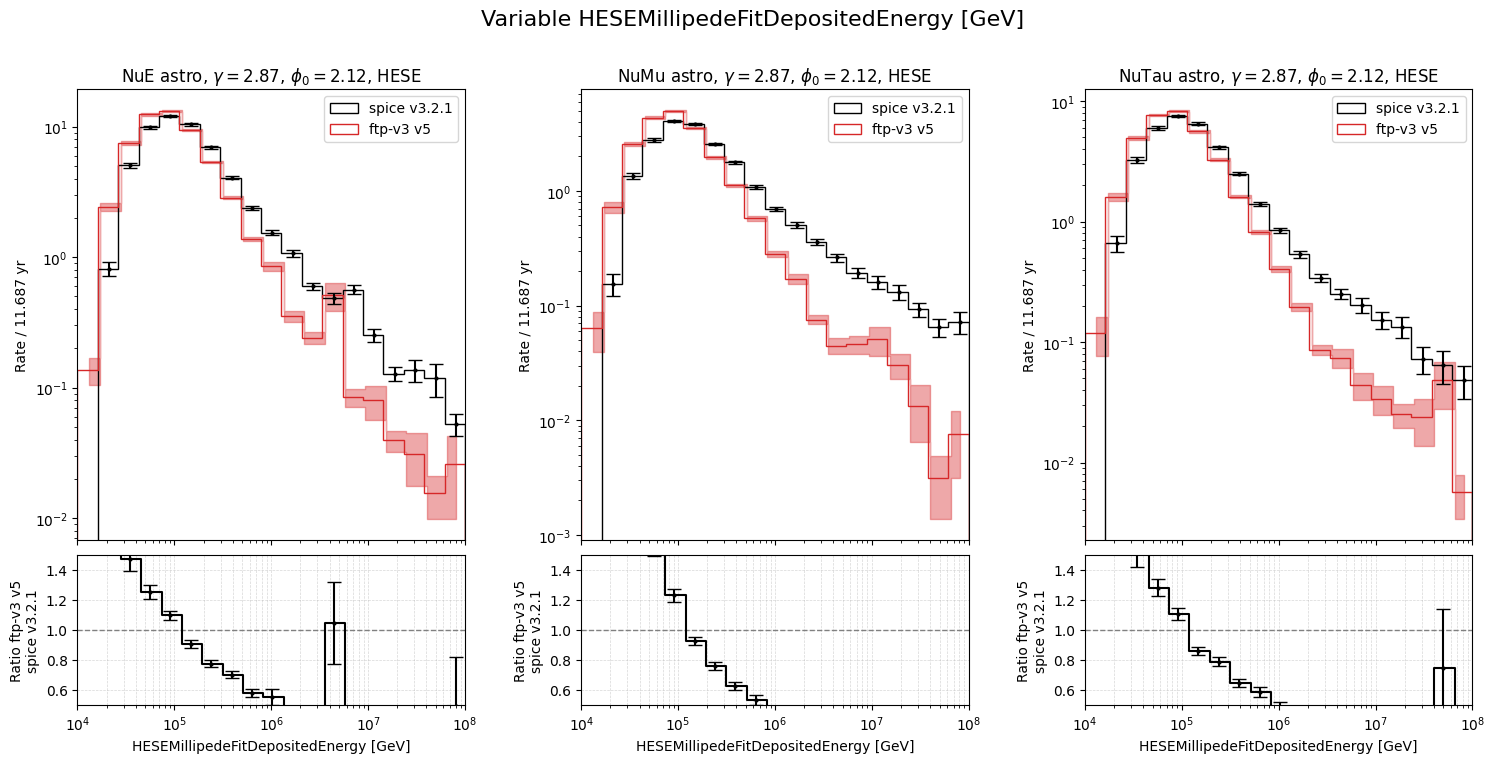

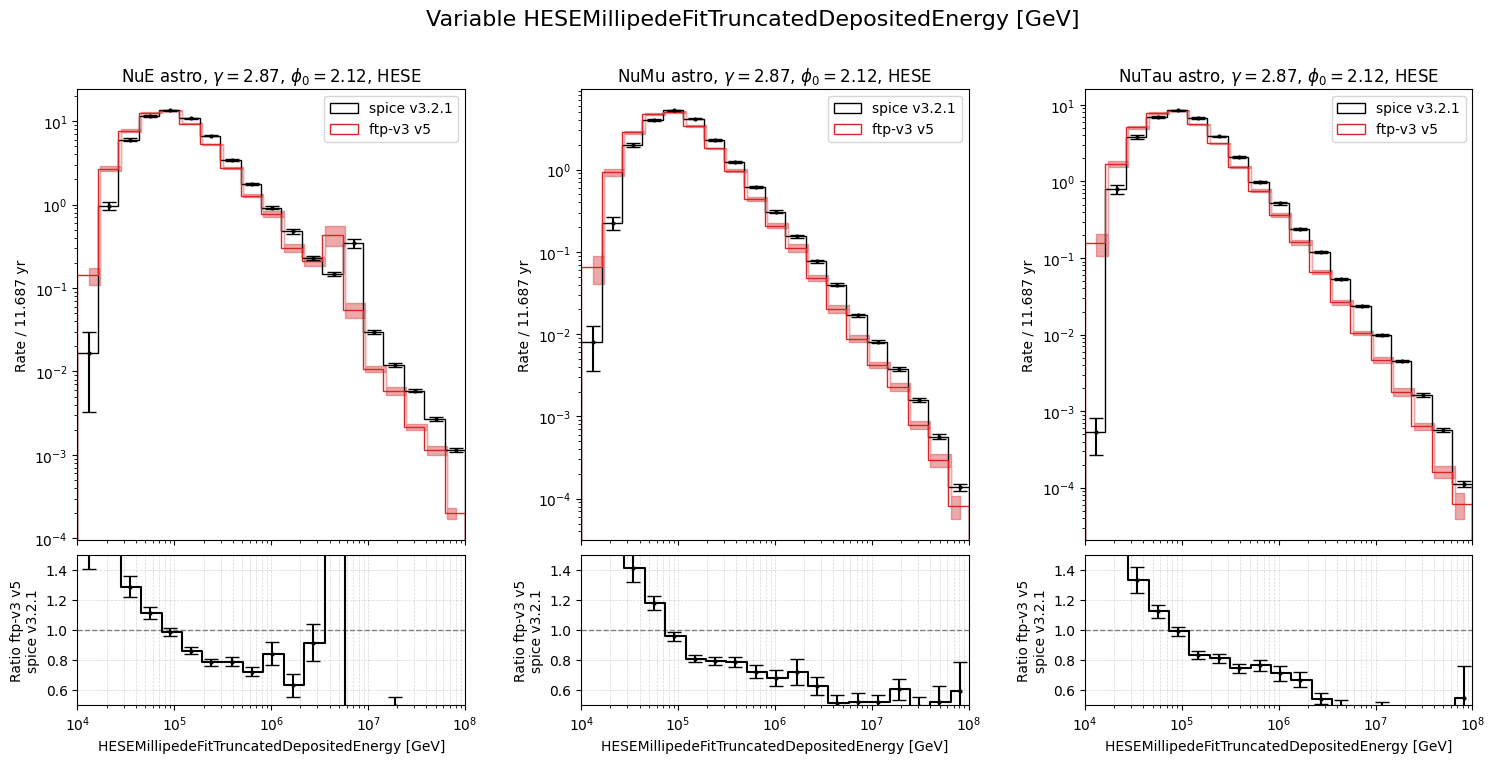

In [21]:
compare_ice_model_flavor( base_key = "spice_tau_reco", base_var_key1 = "HESEMillipedeFitDepositedEnergy", base_var_key2 = "value",
                          alt_key = "v5", alt_var_key1 = "HESEMillipedeFitDepositedEnergy", alt_var_key2 = "value",
                          variable_name = "HESEMillipedeFitDepositedEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="HESEMillipedeFitDepositedEnergy_v5" )


compare_ice_model_flavor( base_key = "spice_tau_reco", base_var_key1 = "HESEMillipedeFitTruncatedDepositedEnergy", base_var_key2 = "value",
                          alt_key = "v5", alt_var_key1 = "HESEMillipedeFitTruncatedDepositedEnergy", alt_var_key2 = "value",
                          variable_name = "HESEMillipedeFitTruncatedDepositedEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="HESEMillipedeFitTruncatedDepositedEnergy_v5" )

/tmp/ipykernel_51180/2900361815.py:55: RuntimeWarning: invalid value encountered in divide
  ratio = hist2 / hist1
/tmp/ipykernel_51180/2900361815.py:73: RuntimeWarning: invalid value encountered in divide
  (hist1_error / hist1)**2 + (hist2_error / hist2)**2


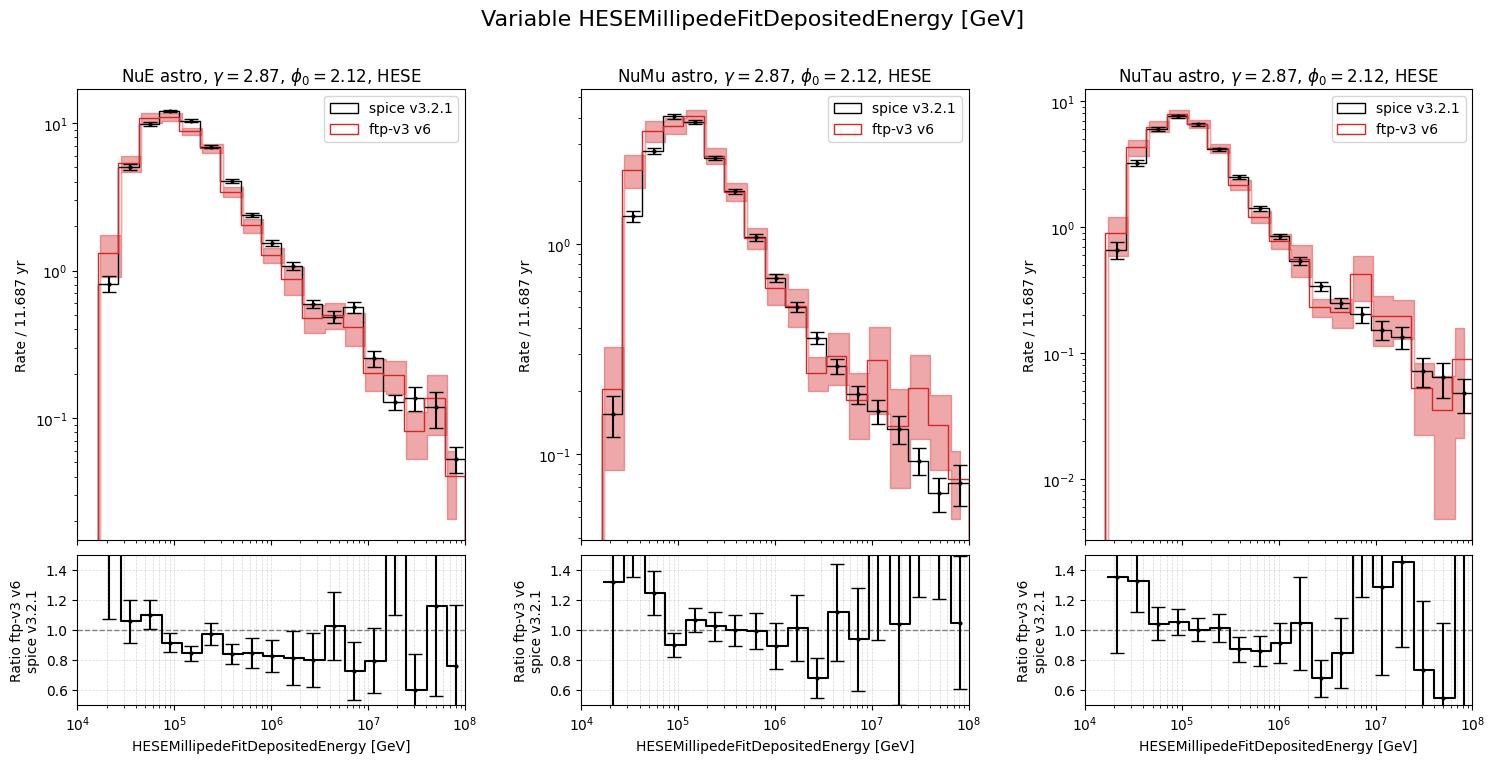

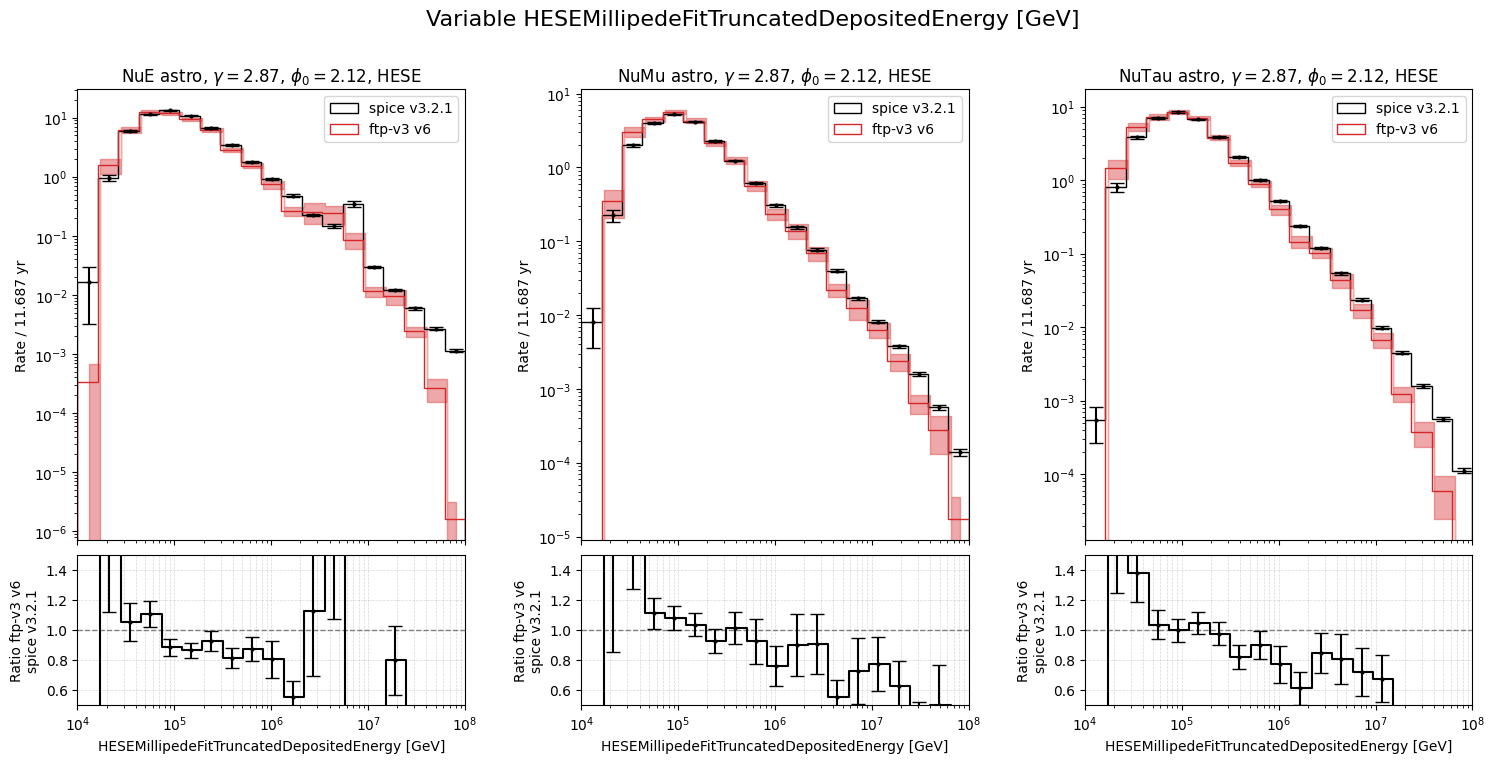

In [22]:
compare_ice_model_flavor( base_key = "spice_tau_reco", base_var_key1 = "HESEMillipedeFitDepositedEnergy", base_var_key2 = "value",
                          alt_key = "v6", alt_var_key1 = "HESEMillipedeFitDepositedEnergy", alt_var_key2 = "value",
                          variable_name = "HESEMillipedeFitDepositedEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="HESEMillipedeFitDepositedEnergy_v6" )


compare_ice_model_flavor( base_key = "spice_tau_reco", base_var_key1 = "HESEMillipedeFitTruncatedDepositedEnergy", base_var_key2 = "value",
                          alt_key = "v6", alt_var_key1 = "HESEMillipedeFitTruncatedDepositedEnergy", alt_var_key2 = "value",
                          variable_name = "HESEMillipedeFitTruncatedDepositedEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 20), xscale = "log", yscale = "log", savename="HESEMillipedeFitTruncatedDepositedEnergy_v6" )

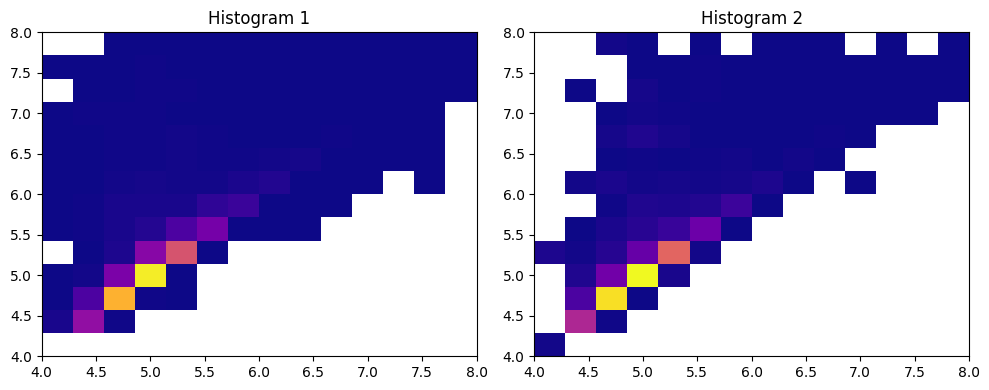

In [31]:
flavor = "NuTau"
variable = "HESEMillipedeFitDepositedEnergy"
true_variable = "TrueETot"

bins = (np.linspace(4,8,15),np.linspace(4,8,15))
# bins = (np.linspace(6,8,15),np.linspace(6,8,15))

base_key = "spice_tau_reco"
alt_key = "v6"

cmap = plt.colormaps['plasma']

var_base_reco = np.log10(simulation_datasets[base_key][flavor]["weighter"].get_column(variable, "value"))
var_base_true = np.log10(simulation_datasets[base_key][flavor]["weighter"].get_column(true_variable, "value"))
weights_base = simulation_datasets[base_key][flavor]["weights_astro"]

var_alt_reco = np.log10(simulation_datasets[alt_key][flavor]["weighter"].get_column(variable, "value"))
var_alt_true = np.log10(simulation_datasets[alt_key][flavor]["weighter"].get_column(true_variable, "value"))
weights_alt = simulation_datasets[alt_key][flavor]["weights_astro"]

# Compute histograms
H1, _, _ = np.histogram2d(var_base_true, var_base_reco, bins=bins, weights=weights_base)
H2, _, _ = np.histogram2d(var_alt_true, var_alt_reco,   bins=bins, weights=weights_alt)

# Make copies so you don't overwrite original data
H1_masked = np.where(H1 == 0, np.nan, H1)
H2_masked = np.where(H2 == 0, np.nan, H2)

# Shared color scale
vmin = min(H1.min(), H2.min())
vmax = max(H1.max(), H2.max())

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First 2D histogram
# h1 = axes[0].hist2d(var_base_true, var_base_reco, bins=bins, vmin=vmin,vmax=vmax,
#                     weights=weights_base, cmap='viridis')
h1 = axes[0].pcolormesh(bins[0], bins[1], H1_masked.T, vmin=vmin,vmax=vmax,cmap=cmap)
axes[0].set_title('Histogram 1')
# fig.colorbar(h1[3], ax=axes[0])

# Second 2D histogram
# h2 = axes[1].hist2d(var_alt_true, var_alt_reco, bins=bins, vmin=vmin,vmax=vmax,
#                     weights=weights_alt,cmap='viridis')
h2 = axes[1].pcolormesh(bins[0], bins[1], H2_masked.T, vmin=vmin,vmax=vmax, cmap=cmap)

axes[1].set_title('Histogram 2')
# fig.colorbar(h2[3], ax=axes[1])

plt.tight_layout()
plt.show()

In [34]:
from common import calculator


def plot_quartiles_vs_x(deltas, lge_tru, lge_bins, label):
    if np.any(np.isnan(deltas)):
        print(
            f'WARN: {len(deltas[np.isnan(deltas)])} nan events. Ignored in quartiles.')
    lge_i = np.digitize(lge_tru, lge_bins)
    digitized_deltas = [deltas[lge_i == ei] for ei in range(1, lge_bins.size)]

    per50 = [np.nanmedian(ca) for ca in digitized_deltas]
    per25 = [np.nanpercentile(ca, 25) if len(
        ca) > 0 else np.nan for ca in digitized_deltas]
    per75 = [np.nanpercentile(ca, 75) if len(
        ca) > 0 else np.nan for ca in digitized_deltas]
    plt.plot(calculator.centers(lge_bins), per50, label=label+' quartiles')
    plt.fill_between(calculator.centers(lge_bins), per25, per75, alpha=0.5)
    return per25, per50, per75

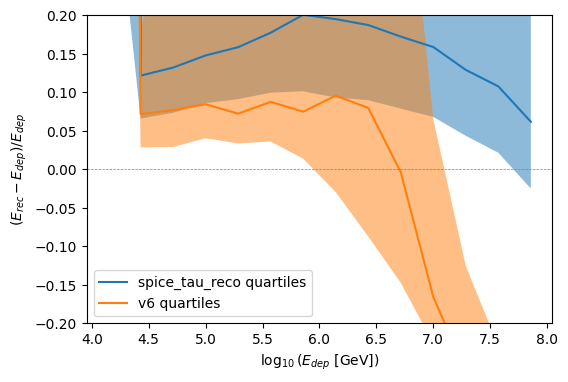

In [35]:
plt.figure(figsize=(6, 4))

bins = np.linspace(4,8,15)

for label in  ["spice_tau_reco","v6"]:
    
    loge_fit = np.log10(simulation_datasets[label][flavor]["weighter"].get_column(variable, "value"))
    loge_tru = np.log10(simulation_datasets[label][flavor]["weighter"].get_column(true_variable, "value"))
    
    plot_quartiles_vs_x((10**(loge_fit)-10**(loge_tru))/10**(loge_tru),
                        loge_tru,
                        bins,
                        label)
plt.axhline(0, linewidth=0.5, color='gray', linestyle='--')
plt.xlabel(r'$\log_{10}(E_{dep}$ [GeV]$)$')
plt.ylabel('$(E_{rec}-E_{dep})/E_{dep}$')
plt.ylim(-0.2, 0.2)
plt.legend()

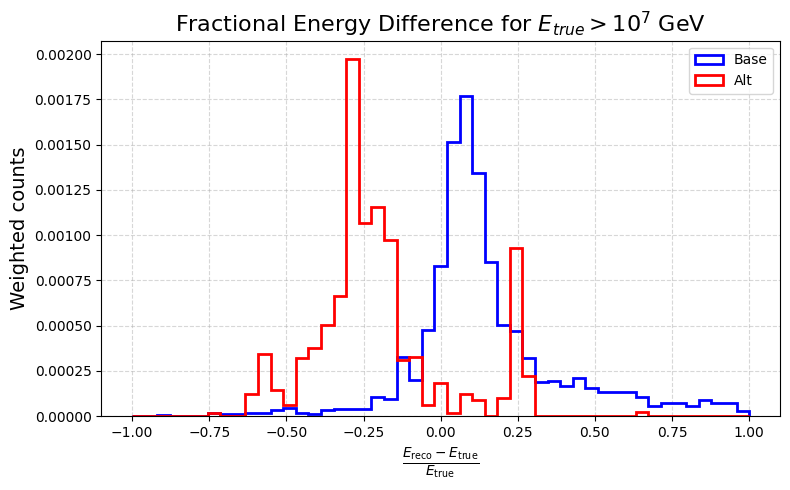

In [36]:
var_base_reco = np.log10(simulation_datasets[base_key][flavor]["weighter"].get_column(variable, "value"))
var_base_true = np.log10(simulation_datasets[base_key][flavor]["weighter"].get_column(true_variable, "value"))
weights_base = simulation_datasets[base_key][flavor]["weights_astro"]

var_alt_reco = np.log10(simulation_datasets[alt_key][flavor]["weighter"].get_column(variable, "value"))
var_alt_true = np.log10(simulation_datasets[alt_key][flavor]["weighter"].get_column(true_variable, "value"))
weights_alt = simulation_datasets[alt_key][flavor]["weights_astro"]

# Mask for events where log10(E_true) > 7
mask_base = var_base_true > 7
mask_alt  = var_alt_true > 7

# Compute fractional difference: (E_reco - E_true) / E_true
frac_diff_base = (10**var_base_reco[mask_base] - 10**var_base_true[mask_base]) / (10**var_base_true[mask_base])
frac_diff_alt  = (10**var_alt_reco[mask_alt]  - 10**var_alt_true[mask_alt])   / (10**var_alt_true[mask_alt])

# Apply weights
weights_base_masked = weights_base[mask_base]
weights_alt_masked  = weights_alt[mask_alt]

# Plot 1D histograms
plt.figure(figsize=(8,5))
bins = np.linspace(-1, 1, 50)  # adjust range if needed

plt.hist(frac_diff_base, bins=bins, weights=weights_base_masked, histtype='step', 
         linewidth=2, label='Base', color='blue')
plt.hist(frac_diff_alt,  bins=bins, weights=weights_alt_masked,  histtype='step', 
         linewidth=2, label='Alt', color='red')

plt.xlabel(r'$\frac{E_{\mathrm{reco}} - E_{\mathrm{true}}}{E_{\mathrm{true}}}$', fontsize=14)
plt.ylabel('Weighted counts', fontsize=14)
plt.title('Fractional Energy Difference for $E_{true} > 10^7$ GeV', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
